In [1]:
import mlflow
import mlflow.sklearn
import pandas as pd
import matplotlib.pyplot as plt
 
from numpy import savetxt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

C:\Users\0030A5744\Anaconda3\envs\myenv\lib\site-packages\requests\__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
import os

In [3]:
os.environ["AWS_ACCESS_KEY_ID"] = ""
os.environ["AWS_SECRET_ACCESS_KEY"] = ""
os.environ["MLFLOW_S3_ENDPOINT_URL"] = ""

In [4]:
EXPERIMENT_NAME = "modelVersionControl_metricsParametersLogiing_sklearn"
mlflow.set_tracking_uri('')
mlflow.set_experiment(EXPERIMENT_NAME)
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
print("experiment_id:", experiment.experiment_id)

experiment_id: 4


In [5]:
db = load_diabetes()
X = db.data
y = db.target
X_train, X_test, y_train, y_test = train_test_split(X, y)

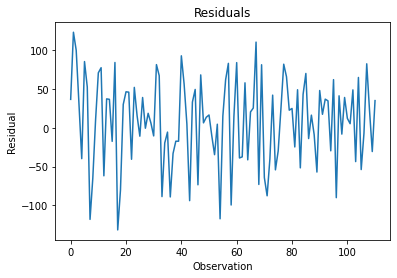

In [7]:
with mlflow.start_run() as model_tracking_run:
  
  # Set the model parameters. 
  n_estimators = 100
  max_depth = 6
  max_features = 3
  
  # Create and train model.
  rf = RandomForestRegressor(n_estimators = n_estimators, max_depth = max_depth, max_features = max_features)
  rf.fit(X_train, y_train)
  
  # Use the model to make predictions on the test dataset.
  predictions = rf.predict(X_test)
  
  # Log the model parameters used for this run.
  mlflow.log_param("num_trees", n_estimators)
  mlflow.log_param("maxdepth", max_depth)
  mlflow.log_param("max_feat", max_features)
  
  # Define a metric to use to evaluate the model.
  mse = mean_squared_error(y_test, predictions)
    
  # Log the value of the metric from this run.
  mlflow.log_metric("mse", mse)
  
  # Log the model created by this run.
  mlflow.sklearn.log_model(rf, "random-forest-model") 
  
  # Save the table of predicted values
  savetxt('predictions.csv', predictions, delimiter=',')
  
  # Log the saved table as an artifact
  mlflow.log_artifact("predictions.csv")
  
  # Convert the residuals to a pandas dataframe to take advantage of graphics capabilities
  df = pd.DataFrame(data = predictions - y_test)
  
  # Create a plot of residuals
  plt.plot(df)
  plt.xlabel("Observation")
  plt.ylabel("Residual")
  plt.title("Residuals")
 
  # Save the plot and log it as an artifact
  
  plt.savefig("residuals_plot.png")
  mlflow.log_artifact("residuals_plot.png") 

In [8]:
run_id = model_tracking_run.info.run_id
print("run_id: {}; lifecycle_stage: {}".format(run_id,
    mlflow.get_run(run_id).info.lifecycle_stage))

run_id: 6c1752e96d504675a7046191b6a63755; lifecycle_stage: active


In [10]:
# use the run_id to construct a logged_model URI. An example is shown here:
# logged_model = 'runs:/37a3fe9b6faf41d89001eca13ad6ca47/model'
logged_model = f'runs:/{run_id}/random-forest-model'


# Load model as a pytorch model, not as the pyfunc model
model = mlflow.sklearn.load_model(logged_model)

In [11]:
model

RandomForestRegressor(max_depth=6, max_features=3)

In [20]:
model.predict([X_test[0]])

array([104.78725973])

In [21]:
# register the model
model_registry_version = mlflow.register_model(logged_model, 'Sckiti_learn')
print(f'Model Name: {model_registry_version.name}')
print(f'Model Version: {model_registry_version.version}')

Registered model 'Sckiti_learn' already exists. Creating a new version of this model...
2022/08/09 10:37:43 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: Sckiti_learn, version 2


Model Name: Sckiti_learn
Model Version: 2


Created version '2' of model 'Sckiti_learn'.
